# Unsupervised evaluation of LLMs using LLMs

_License information_

    Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
    SPDX-License-Identifier: MIT-0

This notebook shows how to use an LLM to evaluate the work of other LLMs.

In this simple example, we will load a canned summarization dataset from Hugging Face. We will obtain summaries from two LLMs, Falcon 40B Instruct BF16 and Flan T5 XL. We will ask Anthropic's Claude model to evaluate those summaries, along with the ground truth summary.

## Prerequisites

You will need an [API key](https://docs.anthropic.com/claude/docs/getting-access-to-claude) to use Claude. In the future you can use [Amazon Bedrock](https://aws.amazon.com/bedrock/) instead, as it offers Claude as a supported model.

In [3]:
claude_api_key = '' ## Enter your API key here

You will also need to install several Python modules.

In [ ]:
!pip install datasets

In [ ]:
! pip install -U anthropic

In [ ]:
! pip install -U pydantic==1.10

Finally, define the names of the SageMaker endpoints you're using for Falcon and Flan-T5.

In [4]:
t5_ep_name = '' # Enter the name of the SageMaker inference endpoint you deployed with Flan-T5

In [5]:
falcon_ep_name = '' # Enter the name of the SageMaker inference endpoint you deployed with Falcon 40B

## Dataset

We'll use the cnn_dailymail dataset. We'll only process five samples to save time.

In [6]:
from datasets import load_dataset

dataset = load_dataset('cnn_dailymail', '3.0.0')

/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Found cached dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [8]:
dataset['train']['article'][0]

'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details o

In [9]:
dataset['train']['highlights'][0]

"Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .\nYoung actor says he has no plans to fritter his cash away .\nRadcliffe's earnings from first five Potter films have been held in trust fund ."

In [10]:
import numpy as np
num_to_eval = 5
eval_idxs = np.random.randint(low=0, high=len(dataset['train']), size=num_to_eval)
eval_idxs

array([143884,  60192,  54750, 117176, 138558])

In [11]:
docs_to_summarize = [dataset['train']['article'][i] for i in eval_idxs]

In [12]:
len(docs_to_summarize)

5

In [13]:
docs_gt = [dataset['train']['highlights'][i] for i in eval_idxs]# ## Get summaries 

## Get summaries 

### Flan-T5

In [14]:
import time

In [15]:
from sagemaker.serializers import JSONSerializer
import sagemaker

t5_ep = t5_ep_name
t5_predictor = sagemaker.predictor.Predictor(t5_ep)
t5_predictor.serializer = JSONSerializer()
t5_predictor.content_type = "application/json"

In [16]:
import json

def query_t5(predictor, doc):
    payload = {
        "text_inputs": f"Write a short summary for this text: \"{doc}\"",
        "max_length": 5000,
        "do_sample": True,
        "top_k": 10,
    }
    response = json.loads(predictor.predict(payload))
    return response['generated_texts'][0]

In [17]:
t5_sums = []
for doc in docs_to_summarize:
    response = query_t5(t5_predictor, doc)
    t5_sums.append(response)
    time.sleep(2)
    

In [18]:
t5_sums[0]

'Jury selection will begin in the trial of Andre Leteve, who is accused of gunning down his two boys in 2010. He is accused of doing it as an act of vengeance against his wife Laurie, with whom he was locked in a bitter divorce battle.'

### Falcon

In [19]:
from sagemaker.serializers import JSONSerializer
import sagemaker

falcon_ep = falcon_ep_name
falcon_predictor = sagemaker.predictor.Predictor(falcon_ep)
falcon_predictor.serializer = JSONSerializer()
falcon_predictor.content_type = "application/json"

In [23]:
import json

def query_falcon(predictor, doc):
    payload = {
        "inputs": f"\"{doc[:950]}\". Summarize the article above:",
        "max_new_tokens": 300,
        "return_full_text": False
    }
    response = json.loads(predictor.predict(payload))
    return response[0]['generated_text']

In [24]:
falcon_sums = []
for doc in docs_to_summarize:
    response = query_falcon(falcon_predictor, doc)
    falcon_sums.append(response)
    time.sleep(2)

In [25]:
falcon_sums[0]

'\nThe article above is about an Arizona man named Andre Leteve who is accused of murdering his'

## Evaluation

In [26]:
from anthropic import Anthropic, HUMAN_PROMPT, AI_PROMPT

anthropic = Anthropic(api_key=claude_api_key)


In [27]:
prompt_eng_base = '''You will be given a summmary of a news article. Your task is to evaluate the summary in four dimensions, accuracy, coherence, factuality, and completeness. Provide a score of 1-5 in each dimension, with 5 being the best score.

Original discussion: [DISCUSSION]

Summary: [SUMMARY]

Evaluation form (scores only):

- Coherence: 
- Accuracy:
- Factuality:
- Completeness:
'''

In [28]:
def make_prompt(search, context, prompt_eng_base):
    search = search.replace("\"", "'")
    context = context.replace("\"", "'")
    prompt = prompt_eng_base.replace('[DISCUSSION]', context)
    prompt = prompt.replace('[SUMMARY]', search)
    return prompt

In [29]:
def get_eval(prompt):
    completion = anthropic.completions.create(
        model="claude-1",
        max_tokens_to_sample=300,
        prompt=f"{HUMAN_PROMPT} {prompt} {AI_PROMPT}",
    )
    return completion.completion

Example output:
    
    "\nSummary Scores:\n\nCoherence: 5\nAccuracy: 5 \nFactuality: 5\nCompleteness: 2\n\nComments: The summary is coherent, accurate and factual in reporting the key details about Daniel Radcliffe gaining access to his trust fund as he turns 18, and his stated plans to not spend extravagantly. However, the summary lacks details on Radcliffe's acting work beyond the Harry Potter series, his upcoming films My Boy Jack and December Boys, as well as his stage debut in Equus. The summary is incomplete in covering the breadth of topics discussed in the original report. Overall, this is a decent high-level summary but could be more complete."

In [30]:
import re
def parse_result(r):
    m = re.search("Accuracy: (\d)", r)
    if m is None:
        accuracy = 0
    else:
        accuracy = m.group(1)
        
    m = re.search("Coherence: (\d)", r)
    if m is None:
        coherence = 0
    else:
        coherence = m.group(1)
        
    m = re.search("Factuality: (\d)", r)
    if m is None:
        factuality = 0
    else:
        factuality = m.group(1)
        
    m = re.search("Completeness: (\d)", r)
    if m is None:
        completeness = 0
    else:
        completeness = m.group(1)
    
    return accuracy, coherence, factuality, completeness

In [31]:
result_map = []
for doc, t5_sum, falcon_sum, gt in zip(docs_to_summarize, t5_sums, falcon_sums, docs_gt):
    p_t5 = make_prompt(t5_sum, doc, prompt_eng_base)
    p_falcon = make_prompt(falcon_sum, doc, prompt_eng_base)
    p_gt = make_prompt(gt, doc, prompt_eng_base)
    
    r_t5 = get_eval(p_t5)
    time.sleep(5)
    r_falcon = get_eval(p_falcon)
    time.sleep(5)
    r_gt = get_eval(p_gt)
    time.sleep(5)
    
    metrics_t5 = parse_result(r_t5)
    metrics_falcon = parse_result(r_falcon)
    metrics_gt = parse_result(r_gt)
    
    result_map.append({
        'doc': doc,
        't5': {
            'summary': t5_sum,
            'eval': r_t5,
            'accuracy': metrics_t5[0],
            'coherence': metrics_t5[1],
            'factuality': metrics_t5[2],
            'completeness': metrics_t5[3],
        },
        'falcon': {
            'summary': falcon_sum,
            'eval': r_falcon,
            'accuracy': metrics_falcon[0],
            'coherence': metrics_falcon[1],
            'factuality': metrics_falcon[2],
            'completeness': metrics_falcon[3],
        },
        'gt': {
            'summary': gt,
            'eval': r_gt,
            'accuracy': metrics_gt[0],
            'coherence': metrics_gt[1],
            'factuality': metrics_gt[2],
            'completeness': metrics_gt[3],
        }
        
    })

In [32]:
result_map[0]

{'doc': "By . Daily Mail Reporter . PUBLISHED: . 12:03 EST, 10 September 2012 . | . UPDATED: . 13:03 EST, 10 September 2012 . Mug shot: Andre Leteve suffered facial injuries after trying to kill himself following the murder of his sons . An Arizona man who stands accused of murdering his two sons at the height of a bitter divorce battle with his wife will stand trial beginning this week. Jury selection is set to begin in the trial of Andre Leteve, who is accused of gunning down his two young sons Alec, 5, and Asher, 1, in Scottsdale on March 31, 2010. Prosecutors are out to prove that Leteve, who was 39 at the time, shot his sons as an act of vengeance against his estranged wife Laurie, with whom he was locked in a bitter divorce battle. Their marriage reportedly soured after she discovered that he had cheated on her with prostitutes. A court document obtained by The Arizona Republic read: 'The state claims one of the motives for killing the sons was revenge because Laurie, [his] wife 

## Results

*Note*: Do not take these results as a comprehensive model evaluation. The purpose of this notebook is to illustrate the evaluation technique. We did not spend any time on model tuning or prompt engineering.

In [33]:
import seaborn as sns

In [34]:
result_values = []
result_types = []
result_models = []
result_docs = []

In [35]:
for r in result_map:
    for m in ['t5', 'falcon', 'gt']:
        for t in ['accuracy', 'coherence', 'factuality', 'completeness']:
            result_docs.append(r['doc'])
            result_values.append(r[m][t])
            result_types.append(t)
            result_models.append(m)

In [36]:
import pandas as pd
df = pd.DataFrame({'doc': result_docs, 'value': result_values, 'type': result_types, 'model': result_models})

In [37]:
df.head()

,doc,value,type,model
0,By . Daily Mail Reporter . PUBLISHED: . 12:03 ...,5,accuracy,t5
1,By . Daily Mail Reporter . PUBLISHED: . 12:03 ...,5,coherence,t5
2,By . Daily Mail Reporter . PUBLISHED: . 12:03 ...,5,factuality,t5
3,By . Daily Mail Reporter . PUBLISHED: . 12:03 ...,3,completeness,t5
4,By . Daily Mail Reporter . PUBLISHED: . 12:03 ...,4,accuracy,falcon


In [38]:
df['value'] = df['value'].astype(int)

<AxesSubplot:xlabel='type', ylabel='value'>

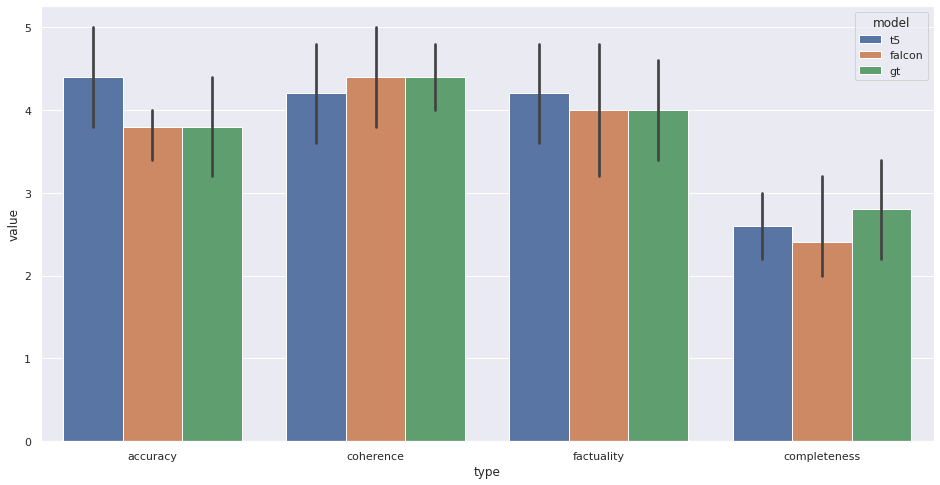

In [39]:
sns.set(rc={"figure.figsize":(16, 8)})
sns.barplot(data=df, x='type', y='value', hue='model')